Tutorial on how to do it: https://moonbooks.org/Articles/How-to-create-a-table-of-contents-in-a-jupyter-notebook-/

Markown cheat sheet: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet

# Table of Contents

* [Introduction](#Introduction)
* [Data Exploration](#DE)
    * [Loading Data](#Loading_data)
    * [Label Parsing](#Label_parsing)
    * [Data Quality](#Data_quality)
        * [Visualization](#Visualization)
        * [Label Distribution](#Distribution)

* [Approach to classify the data](#approach)
    * [Full Data Loading](#full_data)
    * [Data Preparation](#data_prep)
    
* [Modelisation](#model)
    * [Model definition](#model_def)
    * [Model training & performance evaluation](#training)
    * [Inference Part](#inference)
* [Conclusion](#Conclusion)

# Introduction <a class="anchor" id="Introduction"></a>

This notebook is used to develop a machine learning model that can take chess board input images and return the board status following the [Forsyth–Edwards Notation(FEN)](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation).  

It is using the [Kaggle Dataset: Chess Positions](https://www.kaggle.com/koryakinp/chess-positions).

So from the documentation, we notice that the input is a 400x400 pixel image.  
The output will be a string of characters using FEN notation.
This is mainly an image classification problem but the fact that we need to detect and position several pieces per image is making it more interesting and a bit more complex.  
As a first idea, I believe we can take advantage of the images being all the same size and the knowledge that the board is an 8x8 regular table.  
This will allow to transform this problem into a classical image classification for each cell.  
After that pre-processing, it will therefore be quite logical to use a Convolutional Neural Network which is very well known for having good results on image classification.  
The specific architecture of the CNN will be explained later on in this notebook.  

In the future, the output of the Image recognition could be used to predict the next move or to identify the chances of winning from each player.  
One way of doing that would be to use the [Kaggle Dataset: Chess Game (Lichess)](https://www.kaggle.com/datasnaek/chess)  
One point to be noted though, it seems some input images seems to have some pretty unusual game state (3 white bishops for instance) so there may be a need to select the input images for prediction.

# Data Exploration <a class="anchor" id="DE"></a>

First of all we are going to explore the data to understand it better.  
How many images do we have, is there any specificities, etc.  

As always, it is good to start from the Kaggle data description that is already giving useful information:   
- Images are 400x400 pixels
- they are generated from 28 styles of boards and 32 styles of chess pieces. This is quite important as it will impact our model selection. For example, we cannot use a very basic model that would compare images pixel by pixel due to this variety
- there are 80,000 images available in the train set. The test set is discarded at this stage as it is not labeled and only used for Kaggle ranking.


The below information could be useful in a second time but are not essential:
Pieces were generated with the following probability distribution:

30% for Pawn  
20% for Bishop  
20% for Knight  
20% for Rook  
10% for Queen  

2 Kings are guaranteed to be on the board.

## Loading data <a class="anchor" id="Loading_data"></a>
This dataset is a bit different than usual as we don't have the data/label in a form that can be loaded directly in a Dataframe.  
The label is the name of the file so we will need to extract that.  
Then the label is a string and that will be difficult to work with that so there will be a need to parse this string into a format easier to use.

As of this stage, my first idea is to create a parse that will return an 8x8 array that will represent the board.
Then for the images themselves, I will need to convert them into a numpy array to use them in any model.

In [1]:
import numpy as np # Use to store the images as arrays that can be used as input in models
from PIL import Image # Basic library to work with images
import glob # Used to grab the list of file names in a folder. It will be used to load all the images.
import matplotlib.pyplot as plt  # plotting library, it will be used to show the images stored as array in form of images. Could also be used to plot other data if needed.

# here we will load only 100 images to do the exploration

image_list = glob.glob("data_chess/train/*.jpeg") # find all jpeg images in the given path
nb_image = 100
image_size = 400 # we consider that even with another dataset, the images would be square

def load_images_color(image_list, nb_images, image_size=400):
    X = np.empty([nb_images, image_size, image_size, 3], np.int32) # we will store the images in a 4D array with the first dimension being the  
    y = []

    for i, img_path in enumerate(image_list[:nb_images]):
        img_label = img_path.split("\\")[1].split(".")[0] # get label
        img_array = np.array(Image.open(img_path))

        X[i] = img_array
        y.append(img_label)
    return X, y

X_small, y_small = load_images_color(image_list, nb_image, image_size=400)
print(X_small[0].shape)
print(y_small[0])

(400, 400, 3)
1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3


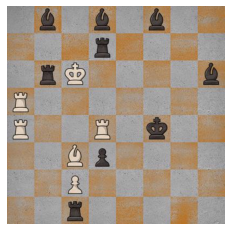

In [2]:
plt.imshow(X_small[1])
plt.axis('off')
plt.show()

The images are in color so as expected we are getting 3 channels in the shape.
This is one of the thing we will need to consider.  
For now I am  more inclined towards using grayscale for 2 reason:
- The data will be smaller so the training should be faster
- since there are several background with several colors, it may be easier to have grayscale which would just have light/dark cells

## Label Parsing <a class="anchor" id="Label_parsing"></a>
As mentioned above, the label as it is will be difficult to use so the idea is to transform it in a numpy array with a label encoder.  
To ease the recognition between white and black pieces I will start from 1 for white pieces and from 11 for black pieces.   
Empty cells will have 0 value.  

In [3]:
# pieces_encoding = {'K': 1, 'Q': 2, 'R': 3, 'B': 4, 'N': 5, 'P': 6, 'k': 11, 'q': 12, 'r': 13, 'b': 14, 'n': 15, 'p': 16}
pieces_encoding = {'K': 1, 'Q': 2, 'R': 3, 'B': 4, 'N': 5, 'P': 6, 'k': 7, 'q': 8, 'r': 9, 'b': 10, 'n': 11, 'p': 12}

# had to change it because of output of NN needs to be continuous and to avoid 2 encodings

In [4]:
def parsing_label(img_label):
    rows = img_label.split("-")

    board_status = np.zeros((8,8))
    for i, row in enumerate(rows):
        col=0
        for c in row:
            if c.isdigit():
                col+=int(c)
            else:
                board_status[i, col] = int(pieces_encoding[c])
                col+=1
    return board_status
            

In [5]:
parsing_label(y_small[0])

array([[ 0., 10.,  0.,  4.,  0., 10.,  0.,  0.],
       [ 0.,  0., 12.,  1.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  0.,  0., 12.,  0.,  9.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9., 10.,  0.,  0.,  0.]])

## Data quality <a class="anchor" id="Data_quality"></a>
Let's have a look at some of these pictures and make sure our classes are well balanced.
This will aslo be the opportunty to check that the parsing is working as expected.

### Visualization <a class="anchor" id="Visualization"></a>

We will just visualise a few images with their label as a string to see the differences.  
We will also use that to confirm that the label encoder works as expected on a few images.

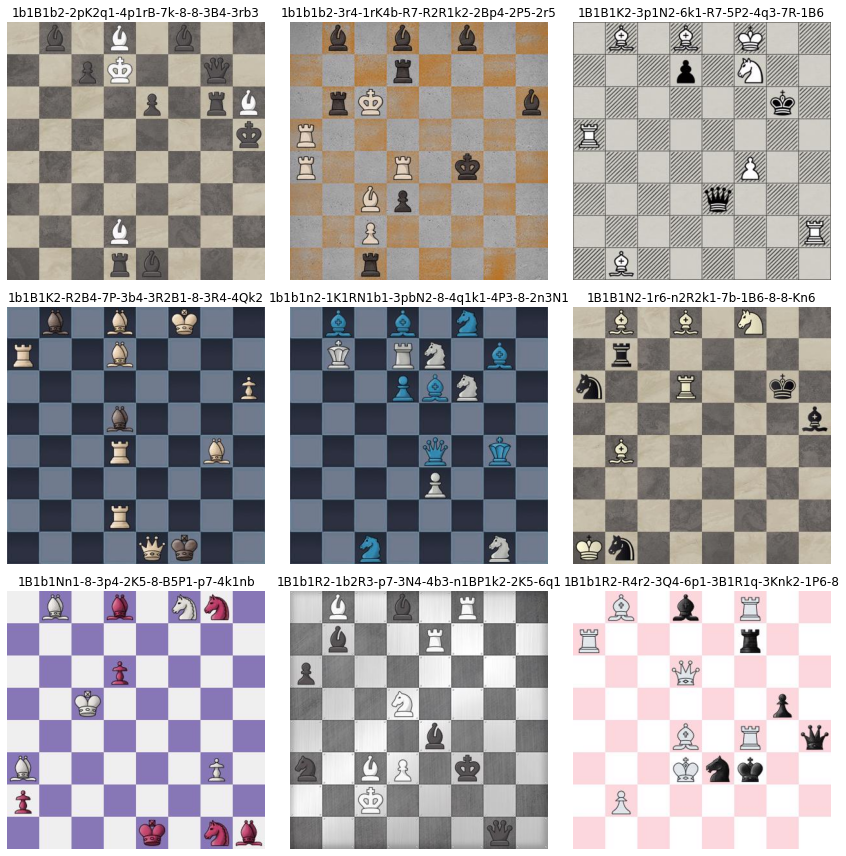

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
i = 0
for y in range(3):
    for x in range(3):  
        img = X_small[i]     
        axs[y,x].imshow(img)
        axs[y,x].set_title(f"{y_small[i]}")
        axs[y,x].set_axis_off()
        
        i += 1
fig.tight_layout()
plt.show()

In [7]:
# let's check the label parsing on the images of the first row 
for i in range(3):
    print(parsing_label(y_small[i]))
    print('\n')

[[ 0. 10.  0.  4.  0. 10.  0.  0.]
 [ 0.  0. 12.  1.  0.  0.  8.  0.]
 [ 0.  0.  0.  0. 12.  0.  9.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  7.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  9. 10.  0.  0.  0.]]


[[ 0. 10.  0. 10.  0. 10.  0.  0.]
 [ 0.  0.  0.  9.  0.  0.  0.  0.]
 [ 0.  9.  1.  0.  0.  0.  0. 10.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  0.  0.  3.  0.  7.  0.  0.]
 [ 0.  0.  4. 12.  0.  0.  0.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.  0.  0.]]


[[ 0.  4.  0.  4.  0.  1.  0.  0.]
 [ 0.  0.  0. 12.  0.  5.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  7.  0.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.]
 [ 0.  0.  0.  0.  8.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.]
 [ 0.  4.  0.  0.  0.  0.  0.  0.]]




### Label Distribution <a class="anchor" id="Distribution"></a>
The Distribution is given in the Kaggle description but I will just compute it on the 50 first images to see if anything is problematic.  
I need first to parse the all 50 labels of y_small.

In [8]:
y_small_parsed = np.empty((nb_image, 8, 8), np.int32)
for i, label in enumerate(y_small):
    y_small_parsed[i] = parsing_label(label)

In [9]:
value_count = {'K': 0, 'Q': 0, 'R': 0, 'B': 0, 'N': 0, 'P': 0, 'k': 0, 'q': 0, 'r': 0, 'b': 0, 'n': 0, 'p': 0}
for k, v in pieces_encoding.items():
    
    count = np.count_nonzero(y_small_parsed == v)
    value_count[k] += count
    print(k, count)
print(value_count)

K 100
Q 35
R 91
B 164
N 84
P 103
k 100
q 48
r 89
b 200
n 104
p 99
{'K': 100, 'Q': 35, 'R': 91, 'B': 164, 'N': 84, 'P': 103, 'k': 100, 'q': 48, 'r': 89, 'b': 200, 'n': 104, 'p': 99}


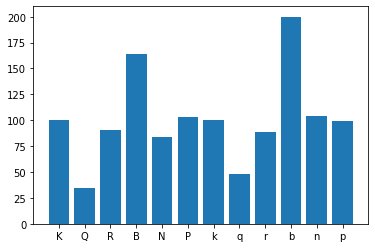

In [10]:
plt.bar(value_count.keys(), value_count.values())
plt.show()

As expected we have 100 kings for each color as the dataset was build with a king on each side.  
The number of queens is much lower as expected as the dataset has only 10% of queens.   
The only surprising result is thate there are much more bishops than other pieces where it should be pawns.    
After a first check I don't see any error in the encoding, we may want to re-check this once the full dataset is loaded 

# Approach to classify the data <a class="anchor" id="approach"></a>

The main idea would be to create an image classifier with a CNN as this is the method that usually gives the best results on images.  
Today, tranformers architectures are becoming more and more interesting for computer vision (although it was first introduced for NLP).  
However, it is much more complex to put in place while CNN with Tensorflow 2 are easy to implement and train.

Since I am using a CNN, I decided not to do much pre-processing and definitely no dimensionality reduction as it will be performed in the Convolutional part of the NN.

The last choice to be made from what was discussed above is about the shape of the input (Grayscale 1 channel or RGB - 3 channels).  
As a first try, I will go with grayscale for smaller inputs.  
In a second time we could use the 3 channels to see if it improve the performance.

My main idea here is to split each image in 64 small images, one for each cell and then train a classifier on these small images.  
I could also use Object detection on the full image to get the position of each items and then backtrack to get the position in the 8x8 board but I think it would be more difficult. 

## Full Data loading <a class="anchor" id="full_data"></a>

It is actually not really possible to load the full data in one variable so I will just load 1000 images for now.
As explained earlier I will now use only grayscale image so the loading code is slightly changed.  
As an improvement later on, I could create a function to load X number of image either in grayscale or in RGB.  

**EDIT**: I have created a **load_images_color()** and a **load_images_gray()** function so both options are available.

In [11]:
%%time
image_list = glob.glob("data_chess/train/*.jpeg") # find all jpeg images in the given path
nb_image = 1000

def load_images_gray(image_list, nb_images, image_size=400):
    X = np.empty([nb_images, image_size, image_size], np.int32) # we will store the images in a 4D array with the first dimension being the  
    y = []

    for i, img_path in enumerate(image_list[:nb_images]):
        img_label = img_path.split("\\")[1].split(".")[0] # get label
        img_array = np.array(Image.open(img_path).convert('L'))

        X[i] = img_array
        y.append(img_label)
    return X, y

X, y = load_images_gray(image_list, nb_image, image_size=400)

print(X[0].shape)
print(y[0])

(400, 400)
1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3
Wall time: 6.93 s


(-0.5, 399.5, 399.5, -0.5)

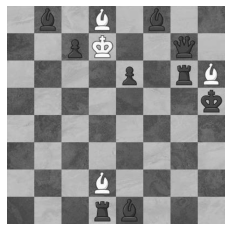

In [12]:
plt.imshow(X[0], cmap='gray')
plt.axis('off')

## Data preparation <a class="anchor" id="data_prep"></a>

Now that I have loaded 1000 images, I need to split my images into 64 smaller images.  
Here also I can see an improvement by doing this directly during the loading of the images, this can be added later on.  
For now I will get all cells and their label but another improvement would likely be to reduce the number of empty cells since it will be the overwhelming majority.  
We will deal with that in a second time if the result are not good.

In [14]:
# Warning, due to memory management, the below changes actually seem to modify the input X,y so this cell can only be run once after loading the images.
# I could look into why later on.

def split_cells(X, y, images_to_process, image_size=400):
    size_cell = image_size//8
    X_cells = np.empty((images_to_process*64, size_cell, size_cell), dtype=np.int32)
    y_cells = np.empty(images_to_process*64)
    y_parsed = [parsing_label(label) for label in y]
    for i in range(images_to_process):
        for j in range(8):
            for k in range(8):
                X_cells[i*64+j*8+k] = X[i][j*size_cell: (j+1)*size_cell, k*size_cell: (k+1)*size_cell]
                y_cells[i*64+j*8+k] = y_parsed[i][j][k]
    return X_cells, y_cells

X_cells, y_cells = split_cells(X, y, nb_image, image_size=400)



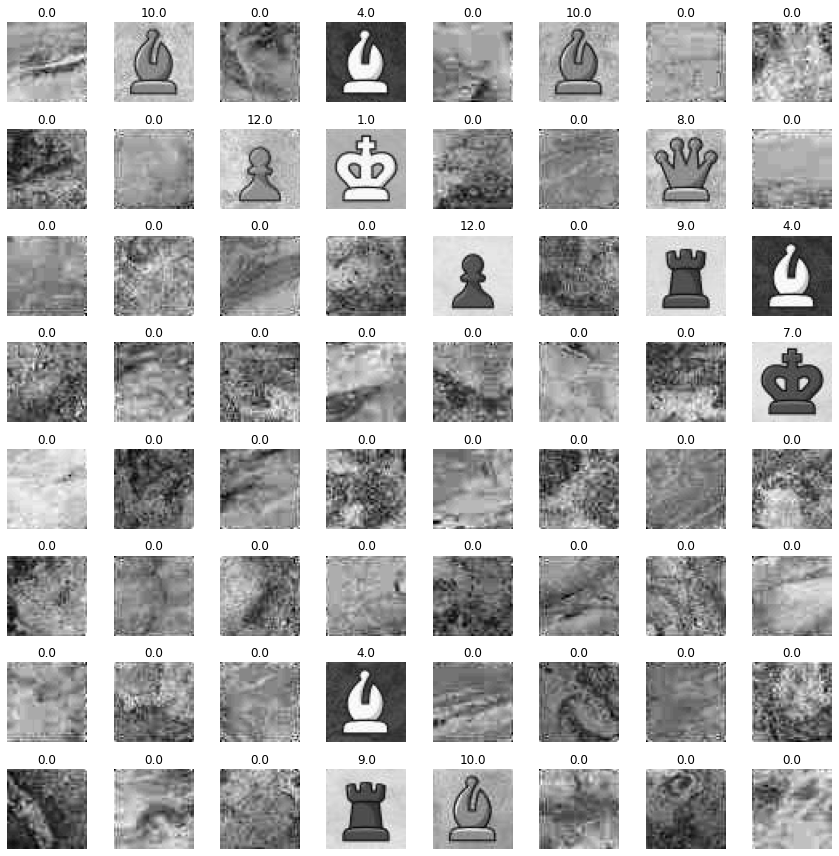

In [15]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
i = 0
for y in range(8):
    for x in range(8):  
        img = X_cells[i]     
        axs[y,x].imshow(img, cmap='gray')
        axs[y,x].set_title(f"{y_cells[i]}")
        axs[y, x].set_axis_off()
        i += 1
fig.tight_layout()
plt.show()

In [16]:
print(X_cells.shape)
print(y_cells.shape)

(64000, 50, 50)
(64000,)


Our dataset is now ready with 64000 small images (50x50) that can be put in a CNN classifier.  
Please note that the image print shows differently when I print the full image and when I print the small images one by one.  
It seems to be due to the way matplotlib handles the image display and not the data itself.  
I checked specific areas and they have the same exact values in the array.

# Modelisation <a class="anchor" id="model"></a>

In this part, I will define the model and train it.  
As usual I will start with a quite simple model with a low number of parameters to see how it goes.

For a CNN, the classical architecture would be:
 - One or several Conv2D layers
 - Each Conv2D layers may or may not be followed by Maxpool2D layer
 - Flatten the output of the Convolutional part
 - Use one or several Dense hidden layers
 - Each hidden layer would normally use a Dropout and potentially a Batch Normalisation. This may be viewed case by case depending on whether we have overfitting etc.
 - Have an output layer with the number of output classes
 
I would create that model with Tensorflow using the Keras Sequential interface as it is the easiest.  
However, I could also use the Functional interface if I want to create a more complex model.

## Model Definition <a class="anchor" id="model_def"></a>

Here I will define the model layer by layer and then compile it.  
To compile the model, I need to chose an optimizer (by default I use 'adam') and a loss.
Since we are using a multi class classifier, I will use the 'sparse_categorial_crossentropy' so that I don't have to use one hot encoding on the classes. 

Finally for the metric, I will use accuracy.  
I can add more later but it is the basics for image classifier.

In [17]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Sequential

In [18]:
CNN_model = Sequential([Conv2D(16, 3, input_shape=(50, 50, 1)),
            MaxPooling2D(),
            Conv2D(8, 3),
            MaxPooling2D(),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(13, activation='softmax')])

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 968)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               124032    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [19]:
CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Model training & performance evaluation <a class="anchor" id="training"></a>

For the model training, I will use the model.fit function.  
As hyper parameters, I will chose the number of epochs, the batch_size and validation_split so that the data will be split automatically between train and validation for performance measurement.

While these parameters can be changed, they mostly have an impact on training time and not really on performance.

For performance I would:
- Check if any overfitting (val_score much lower than training), if it is the case, ensure I use drop out. I could also use more data as for now I have only 64000 small images from 1000 boards.
- Potentially add some hidden layers if the model is not complex enough to learn
- change or add convolution layers

In [20]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show();

In [59]:
epochs = 30
batch_size = 128

history = CNN_model.fit(X_cells[:, : , :, np.newaxis], y_cells, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/30
400/400 [==============================] - 37s 91ms/step - loss: 1.3321 - accuracy: 0.8162 - val_loss: 0.1933 - val_accuracy: 0.9491
Epoch 2/30
400/400 [==============================] - 35s 88ms/step - loss: 0.2520 - accuracy: 0.9215 - val_loss: 0.0569 - val_accuracy: 0.9835
Epoch 3/30
400/400 [==============================] - 36s 90ms/step - loss: 0.1497 - accuracy: 0.9527 - val_loss: 0.0257 - val_accuracy: 0.9915
Epoch 4/30
400/400 [==============================] - 34s 85ms/step - loss: 0.1045 - accuracy: 0.9677 - val_loss: 0.0237 - val_accuracy: 0.9918
Epoch 5/30
400/400 [==============================] - 33s 82ms/step - loss: 0.0808 - accuracy: 0.9743 - val_loss: 0.0153 - val_accuracy: 0.9960
Epoch 6/30
400/400 [==============================] - 32s 80ms/step - loss: 0.0638 - accuracy: 0.9797 - val_loss: 0.0098 - val_accuracy: 0.9964
Epoch 7/30
400/400 [==============================] - 33s 82ms/step - loss: 0.0504 - accuracy: 0.9831 - val_loss: 0.0096 - val_accuracy:

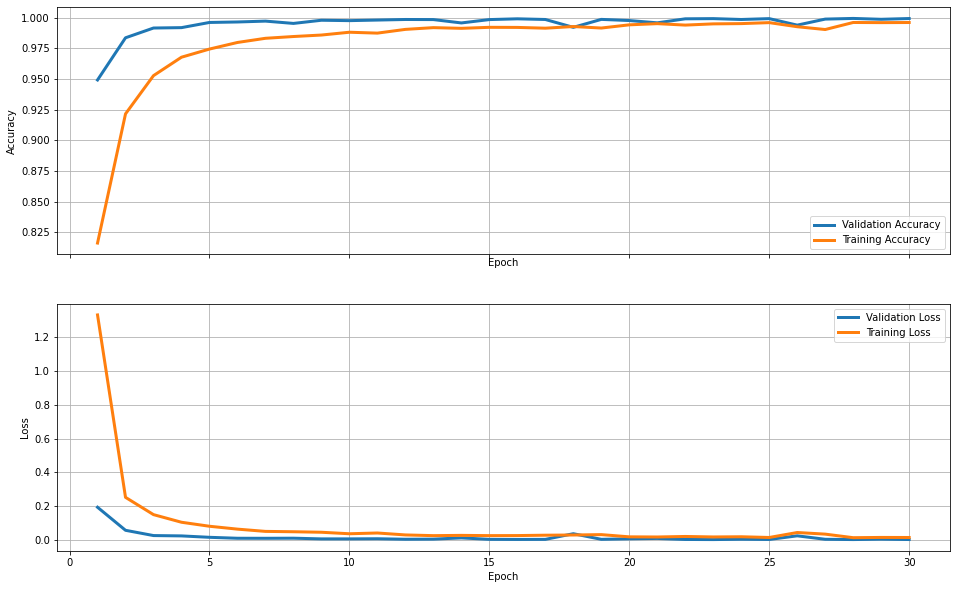

In [61]:
plot_results(history)

### Additional data processing
As mentioned aboved, one drawback of the chosen method is that the training set has a huge number of empty cells compared to the other type of images.  
This kind of unbalanced dataset can lead to over predict the empty cell class.  
Therefore I will balance the dataset to avoid this issue.

I will use this opportunity to use more images, from 1000 to 5000 images.
I will also save the balanced dataset in a CSV which will be easier to use and much simpler to load in Google Colab later on.

In [125]:
import pandas as pd
nb_images = 5000
X, y = load_images_gray(image_list, nb_images, image_size=400)
X_cells, y_cells = split_cells(X, y, nb_images)


data_df = pd.DataFrame(X_cells.reshape(X_cells.shape[0],2500))
data_df['label'] = y_cells
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,label
0,185,186,186,187,188,189,190,190,191,191,...,199,197,193,194,199,200,195,193,187,0.0
1,112,107,109,109,109,105,111,110,108,106,...,102,102,103,104,104,113,105,106,128,10.0
2,188,189,188,178,181,183,186,189,192,193,...,186,190,192,210,192,191,198,203,186,0.0
3,108,119,118,104,96,100,101,96,97,105,...,109,108,109,111,112,111,108,105,103,4.0
4,194,193,192,191,189,188,186,186,192,192,...,191,191,190,190,191,191,191,192,190,0.0


In [126]:
data_df['label'].value_counts()

0.0     267245
10.0      5565
4.0       5527
7.0       5000
1.0       5000
6.0       4638
5.0       4634
12.0      4591
11.0      4590
9.0       4393
3.0       4381
8.0       2223
2.0       2213
Name: label, dtype: int64

In [127]:
# split empty cells and other cells
pieces_df = data_df[data_df['label'] != 0]
empty_cells_df = data_df[data_df['label'] == 0]
# sample random 5000 empty cells in the dataframe
empty_cells_df = empty_cells_df.sample(n=5000)
undersampled_data_df = pd.concat([pieces_df, empty_cells_df])
# as all the empty cells are now at the end of the dataset, let's shuffle it to avoid any issues
undersampled_data_df = undersampled_data_df.sample(frac = 1)
undersampled_data_df['label'].value_counts()

10.0    5565
4.0     5527
0.0     5000
7.0     5000
1.0     5000
6.0     4638
5.0     4634
12.0    4591
11.0    4590
9.0     4393
3.0     4381
8.0     2223
2.0     2213
Name: label, dtype: int64

In [128]:
undersampled_data_df.to_csv('5000_boards_trainset.csv')

### Model updates from above first architecture
With the above model architecture and 30 epochs, I was able to achieve approx more than 99% accuracy on validation set which is already very good.  
There was no sign of overfitting so I reduced a bit the dropout to try to get a bit closer to 100% accuracy.  
I also added BatchNormalisation() layers and added more parameters by adding a Dense layer and the quantity of filters by convolutions.  
The idea is to have a more complex model to be able to learn the last specificities of the images.  
  
  
To ease the computation I used Google Colab GPU so the training output is not visible here.  
I saved the model as **chess_model_best.h5** and this is what I am using for inference below.  
The accuracy on test set is very close to 100% but I may be slightly overfitting the test dataset as I saved the model using a model_checkpoint at each epoch if the val_loss was smaller (see below model **mc** Model_Checkpoint in the training cell)

In [131]:
CNN_model = Sequential([Conv2D(32, 3, input_shape=(50, 50, 1), padding='same'),
            MaxPooling2D(),
            Conv2D(32, 3),
            MaxPooling2D(),
            Conv2D(16, 3),
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(13, activation='softmax')])

CNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 16)          4624      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)              

In [134]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint 
epochs = 200
batch_size = 256

model_filepath = '/model/chess_model.h5'

mc = ModelCheckpoint(
    model_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None)

history = CNN_model.fit(X_cells[:, : , :, np.newaxis], y_cells, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[mc])

## Inference part <a class="anchor" id="inference"></a>

Since I have decided to do a significant part of pre-preprocessing, to get the actual requested result (ie: a label per image in the form of a string using FEN notation), I will need to create a specific inference pipeline.  

This pipeline will be:
- take a full image (or a list of images)
- create the 64 small images per full board
- classify the 64 images per full board
- transform these 64 labels into the FEN notation

**EDIT**: since there is now functions to do the 2 first steps, it is quite simple although a bit long when loading the 20,000 test images.  
Classification step of each cell is straightforward with Tensorflow model.predict().  
Finally a function to inverse parsing is necessary to go back to FEN notation.  
For performance measurement, I will show accuracy and confusion matrix for all the cells predicted class as the first step.  
As the second step, after reconstruction of the FEN notation, I will also check accuracy of the reconstructed file name.

In [21]:
# load test image list 
image_list_test = glob.glob("data_chess/test/*.jpeg")

nb_images_test = 20000 # len(image_list_test)
X_test, y_test = load_images_gray(image_list_test, nb_images_test)

print(X_test[0].shape)
print(y_test[0])

(400, 400)
1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8


In [22]:
X_test_cells, y_test_cells = split_cells(X_test, y_test, nb_images_test)


In [23]:
from tensorflow.keras.models import load_model
size_cell = image_size//8
# load best model from Google Colab
model = load_model('chess_model_final.h5')
# compute result cell by cell
result = np.argmax(model.predict(X_test_cells.reshape((nb_images_test*64, size_cell, size_cell,1))), axis=1)
# reshape result to get the chess board shape
result_board = result.reshape((nb_images_test, 8, 8))
result_board[0]

array([[ 0, 10,  0,  4,  0,  2,  9,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12],
       [ 0,  0,  0,  0,  0,  0,  9,  0],
       [ 0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  7,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [24]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score

print(f'Accuracy on {nb_images_test} test images (ie: {nb_images_test*64} cells) {accuracy_score(y_test_cells,result )*100:.2f}%')
print('\nConfusion matrix:\n', np.array(confusion_matrix(y_test_cells,result )))

Accuracy on 20000 test images (ie: 1280000 cells) 100.00%

Confusion matrix:
 [[1080344       0       0       0       0       0       0       0       0
        0       0       0       0]
 [      0   20000       0       0       0       0       0       0       0
        0       0       0       0]
 [      0       0    8785       0       0       0       0       0       0
        0       0       0       0]
 [      0       0       0   17536       0       0       0       0       0
        0       0       0       0]
 [      0       0       0       0   17700       0       0       0       0
        0       0       0       0]
 [      0       0       0       0       0   17606       0       0       0
        0       0       0       0]
 [      0       0       0       0       0       0   18119       0       0
        0       0       0       0]
 [      0       0       0       0       0       0       0   20000       0
        0       0       0       0]
 [      0       0       0       0       0       0 

In [25]:
# compute the inverse of the encoding dictionnary (from class number to piece letter in FEN notation)
number_to_pieces = {v: k for k,v in pieces_encoding.items()}
print(number_to_pieces)

{1: 'K', 2: 'Q', 3: 'R', 4: 'B', 5: 'N', 6: 'P', 7: 'k', 8: 'q', 9: 'r', 10: 'b', 11: 'n', 12: 'p'}


In [26]:
def array_to_string(board_array):
    """ Function that takes a chess board array with pieces class number
        return a string following FEN notation to describe pieces position on chess board
    """
    out_string = ''
    for i in range(8):
        out_string += '-'
        j = 0
        empty_cells = 0
        while j < 8:
            if board_array[i, j] == 0:
                empty_cells += 1
            else:
                if empty_cells > 0:
                    out_string += str(empty_cells)
                    empty_cells = 0
                out_string += str(number_to_pieces[board_array[i, j]])
            j += 1
        if empty_cells > 0: out_string += str(empty_cells)
    return out_string[1: ]


In [29]:
success = []

for i in range(nb_images_test):
    img = result_board[i]
    out_string = array_to_string(img)
    original_str = image_list_test[i].split('\\')[-1].split('.')[0]
    if i < 5:
        print('predicted string {}:   '.format(i), out_string)
        print('original image name {}:'.format(i), original_str)
    success.append(out_string == original_str)

predicted string 0:    1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8
original image name 0: 1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8
predicted string 1:    1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2
original image name 1: 1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2
predicted string 2:    1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2
original image name 2: 1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2
predicted string 3:    1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2
original image name 3: 1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2
predicted string 4:    1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8
original image name 4: 1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8


In [28]:
print(f'Accuracy of FEN notation predictions over {nb_images_test} test images: {sum(success)/len(success)*100:.2f}%')

Accuracy of FEN notation predictions over 20000 test images: 100.00%


# Conclusion <a class="anchor" id="Conclusion"></a>

The approach I took to split each board into their 64 cells should make the classification much easier, however it requires a lot of pre-processing and post processing.  
As mentioned above, an object detection that returns the recognized object position will require less processing but will be more complex.  
It will also require some form of labeling of the full images which would actually be very similar to the processing I have done.  
Before getting any results, I believe the approach I chose makes sense.  
There may be better ways to do it but I am confident I can get good results.  
I am still unsure about the grayscale choice but it shouldn't be too hard to check.

Another point is that empty cells have all the same label (0), it may be better to have one for white and one for black.
If I get some issue with this, I may change that part.  

As mentioned above, there may be a need to act on the data distribution.  
With my preprocessing, I create an overwhelming number of empty cells and it could lead to the classifier to predict mostly empty cells which would still give a decent accuracy.
I will definitely look into this one, and I will likely have to do undersampling for empty cells.
For the other classes, despite having much more pawns than queens, I think it should still be OK without undersampling.

A final point is the number of different type of pieces and number of colors.   
I don't know how much of an impact it will have, especially since I used only 1000 images for memory (I can probably use more) and the documentation says 896 combination of pieces shape and board colors.

The conclusion will be updated with the actual results of the classifier.

**EDIT**: with the first results, the approach was confirmed being good with more than 99% of correct classification with a basic CNN.  
This gave me the option to increase a bit the complexity of the model, use more images (5000 train images) and do some undersampling on the empty cells.  
With all these changes, I was able to achieve **100%** accuracy on the 20,000 test images.
The whole inference pipeline for 20,000 images is a bit long (overall approx. 15 mins) and we are at the limit of the available memory in my computer.  
As an improvment, it would be better to perform the inference by batches.  
It will avoid the memory intensive operation and it would likely be slightly faster while allowing to have some progress bar to follow progress.  

  
While this method is very accurate, there are other way to perform it, we may be able to use a sliding window classifier which would probably simplify a bit the processing.  
An object detection neural network could also work but I am afraid it would be more complex to put in place and then the localisation of the pieces may not be exact and that would require additional processing. 

Overall I believe the proposed approach is good and would only require to be changed if there is a need for more performance in prediction for important amount of images to process.